# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [ ]:
env = UnityEnvironment(file_name="./Banana_Linux/Banana.x86")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

When finished, you can close the environment.

In [2]:
env.close()

### 4. It's Your Turn!

##### Notice:
If you ran the cells above and especially the last one holding `env.close()` then it is best to restart the notebook kernel now before proceeding.
Otherwise you might run into an error saying:

```python
OSError: handle is closed
```

#### 4.1 Implementation Overview

For an improved readability and better encapsulation the implementation has been split up into several .py files.

- **agent.py**: Holds an implementation of a Deep Q-Learning Agent that is almost identical with the one from the exercise.
- **learning_parameters.py**: Defines a `dataclass` that encapsulates all learning-related hyperparameters
- **model.py**: Defines the architecture for the agents' local and target network using PyTorch. Furthermore, it provides a class `NetworkParameters` that can be used to change the networks parameters like layer sizes.
- **training.py**: Here you can find a function `train_agent` that holds the logic for training an agent. This has been seperated in order to decouple the agents' implementation from the training logic. In addition to that it also provides a function to store a trained model.
- **visualization.py**: Holds a function to visualize the training process of an agent using `matplotlib`.

Run the next cell to import of the modules mentioned above together with the Unity environment.

In [1]:
import logging
import numpy as np
import pandas as pd
from unityagents import UnityEnvironment
from training import DeepQLearningParameters, train_agent, save_agent
from model import NetworkParameters
from agent import Agent
from visualization import plot_agent_learning

logger = logging.getLogger()
level = logger.level
logger.setLevel(logging.CRITICAL)

# Load Unity Environment
env = UnityEnvironment(file_name="./Banana_Linux/Banana.x86")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state_size = len(env_info.vector_observations[0])

logger.setLevel(level)

#### 4.2 Architecture

For the first try we go with the standard Deep Q-Learning algorithm without any of the mentioned improvements.
As the Q-Network architecture we use a simple feed forward network with two hidden layers.

We start with training for **1000 episodes** using **64 nodes** on both hidden layers and a **batch size of 64**.
All additional hyperparameters can be found in the code cell below.

Episode    100	Avg Score:0.96
Episode    200	Avg Score:4.11
Episode    300	Avg Score:8.45
Episode    400	Avg Score:11.15
Episode    500	Avg Score:12.35
Episode    600	Avg Score:14.02
Episode    700	Avg Score:15.44
Episode    800	Avg Score:15.83
Episode    900	Avg Score:16.30
Episode   1000	Avg Score:15.33


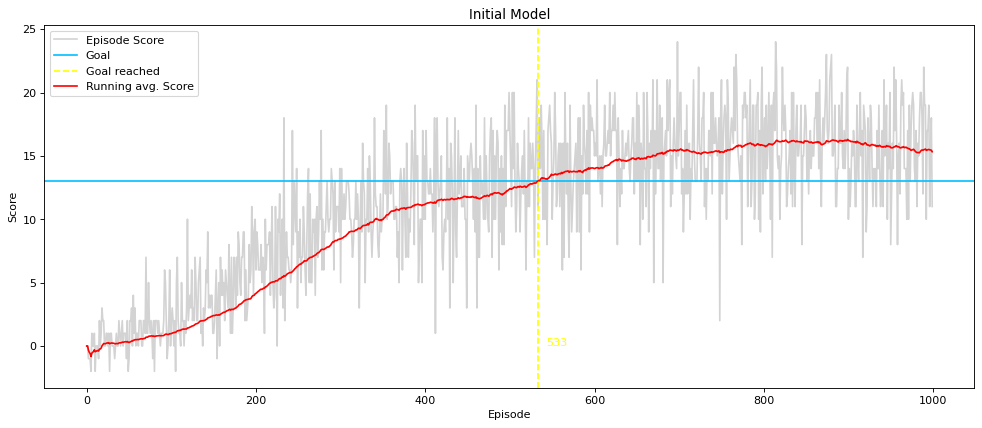

In [2]:
goal_score = 13.0

# Define Network
network_params = NetworkParameters(
    n_states=state_size,
    n_actions=action_size,
    seed=0,
    fc1_size=64,
    fc2_size=64,
    duelling_network=False,
)

# Define Parameters for Q Learning
learning_params = DeepQLearningParameters(
    max_episodes=1000,
    scores_window=100,
    goal_score=goal_score,
    stop_on_goal_reached=False,
    max_t=1000,
    epsilon_start=1.0,
    epsilon_decay=0.995,
    epsilon_min=0.01,
    replay_buffer_size=int(1e5),
    batch_size=64,
    discount_factor=0.99,
    tau=1e-3,
    learning_rate=5e-4,
    update_interval=4,
    double_dqn=False
)

# Build Agent
agent = Agent(learning_parameters=learning_params, network_parameters=network_params)

# Train Agent
episode_scores, running_avg_score = train_agent(agent, env, learning_params)

# Save Agent
save_agent(agent, './saved_models/initial_model.pth')
plot_agent_learning('Initial Model', episode_scores, running_avg_score, goal_score)

As you can see from the chart above the trained model scores the required average score of 13 over 100 episodes after 400-600 episodes of training.

However the scores of the individual episodes are deviating a lot even from the average score even in later episodes.

#### 4.3 Hyperparameter tuning

In order to boost the learning performance and consistence we will vary the following hyperparameters and train 1000 episodes with each combination:
- Hidden layer size: **(64 | 128)**
- Batch size: **(64 | 128 | 256)**
- Update interval: **(4 | 8)**

In [3]:
layer_sizes = [64, 128]
batch_sizes = [64, 128, 256]
update_intervals = [4, 8]

training_results = []

for layer_size in layer_sizes:
    for batch_size in batch_sizes:
        for update_interval in update_intervals:
            model_name = f'{layer_size}_nodes__{batch_size}_batch_size__{update_interval}_update_interval'
            print(f'{model_name}...')

            # Update Hyperparameters
            network_params.fc1_size = layer_size
            network_params.fc2_size = layer_size
            learning_params.batch_size = batch_size
            learning_params.update_interval = update_interval

            # Build Agent
            agent = Agent(learning_parameters=learning_params, network_parameters=network_params)

            # Train Agent
            episode_scores, running_avg_score = train_agent(agent, env, learning_params, log=False)
            training_results.append(((layer_size, batch_size, update_interval), (model_name, episode_scores, running_avg_score)))

            # Save Agent
            save_agent(agent, f'./saved_models/{model_name}.pth')

64_nodes__64_batch_size__4_update_interval...
64_nodes__64_batch_size__8_update_interval...
64_nodes__128_batch_size__4_update_interval...
64_nodes__128_batch_size__8_update_interval...
64_nodes__256_batch_size__4_update_interval...
64_nodes__256_batch_size__8_update_interval...
128_nodes__64_batch_size__4_update_interval...
128_nodes__64_batch_size__8_update_interval...
128_nodes__128_batch_size__4_update_interval...
128_nodes__128_batch_size__8_update_interval...
128_nodes__256_batch_size__4_update_interval...
128_nodes__256_batch_size__8_update_interval...


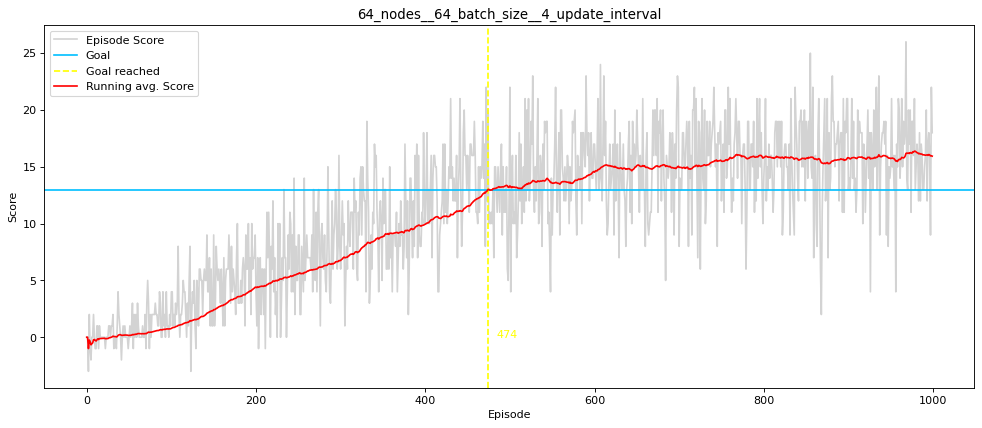

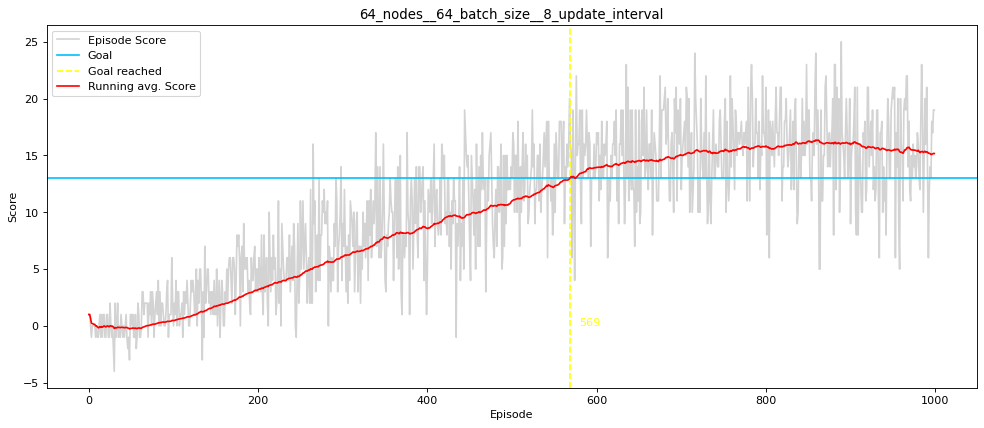

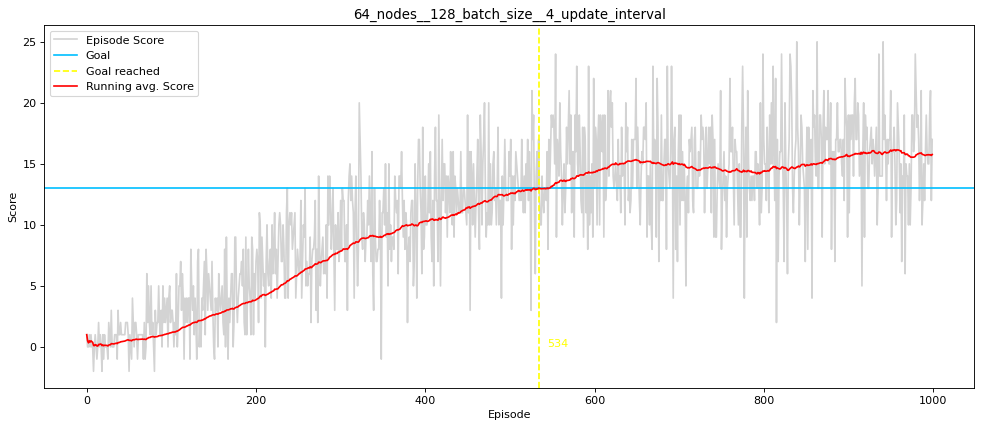

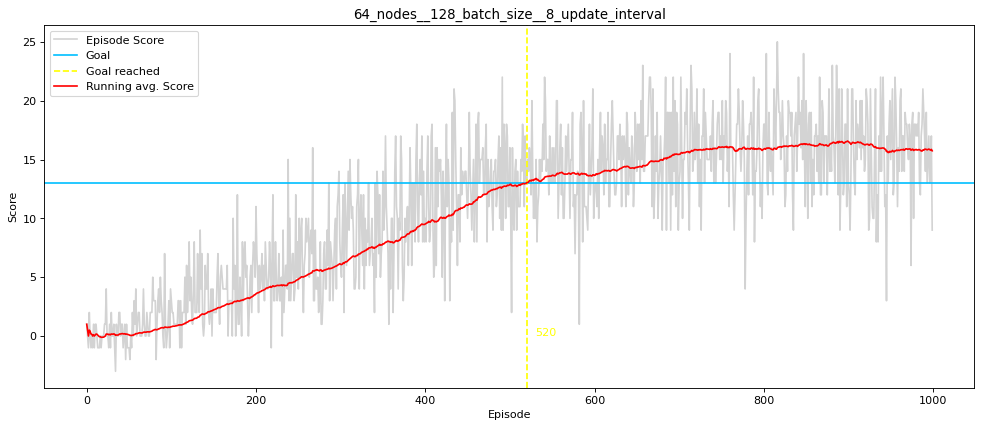

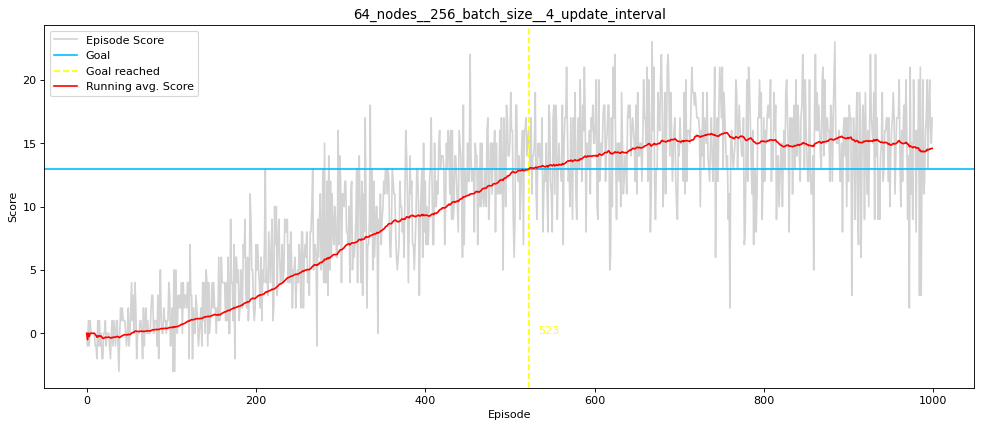

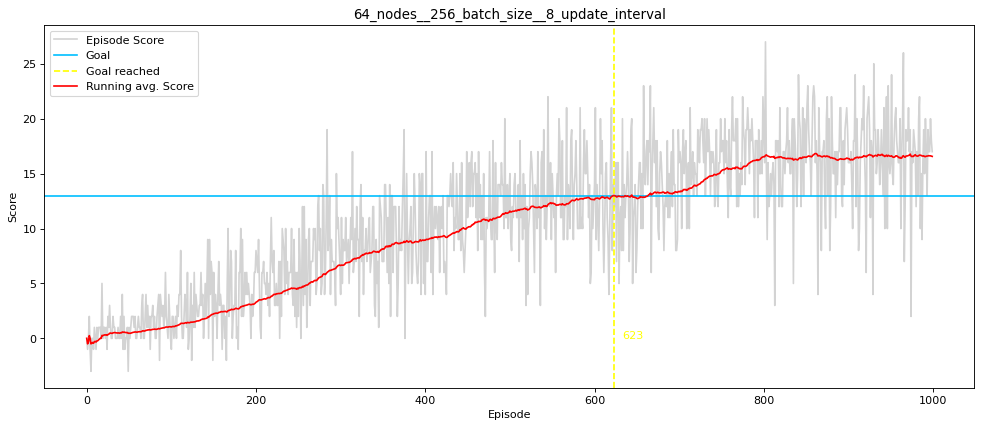

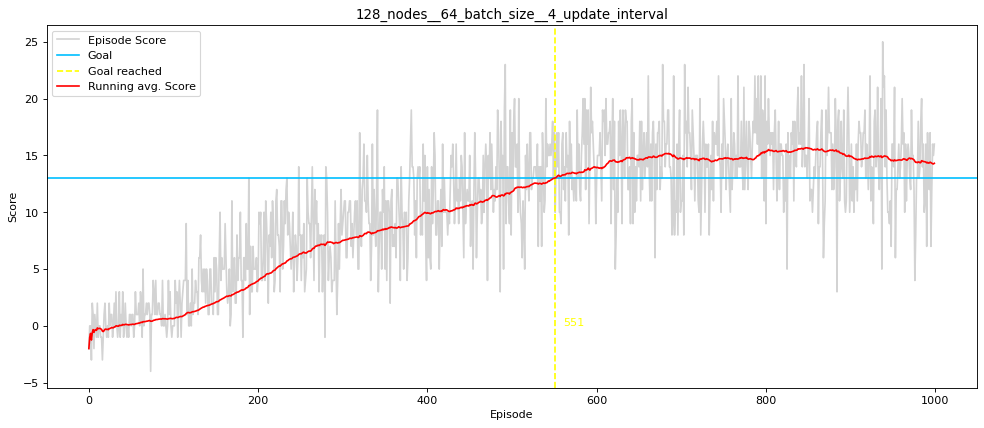

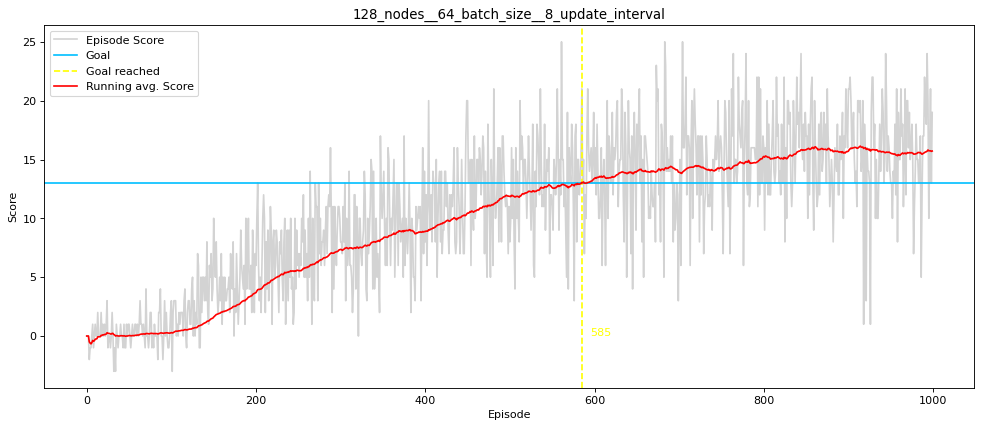

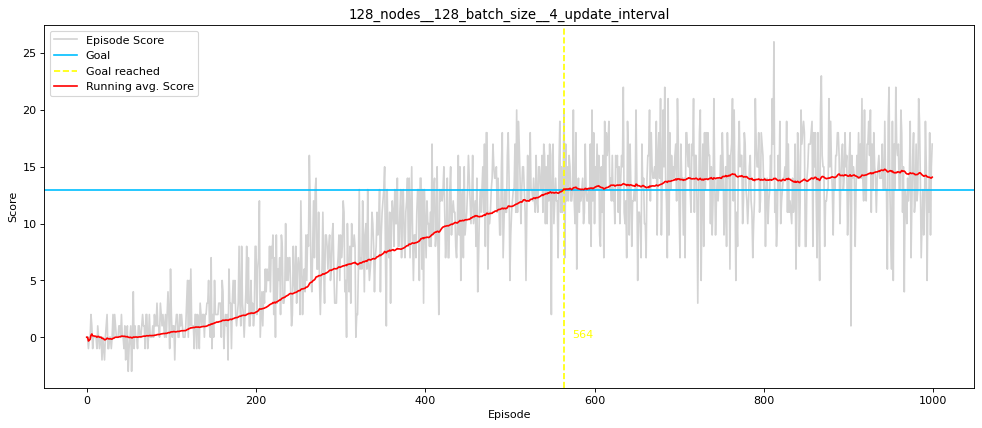

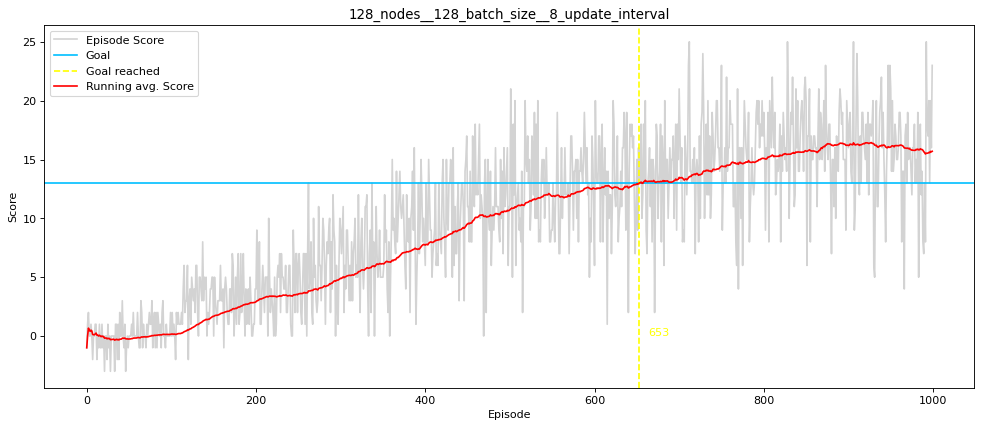

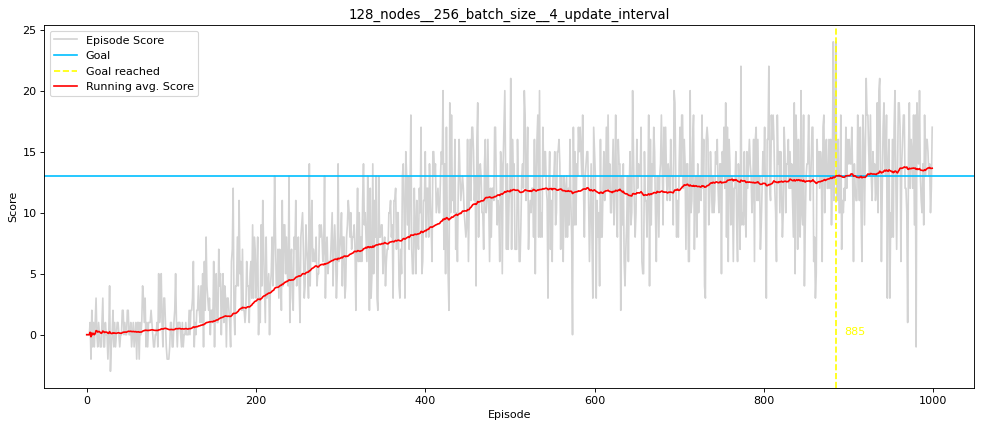

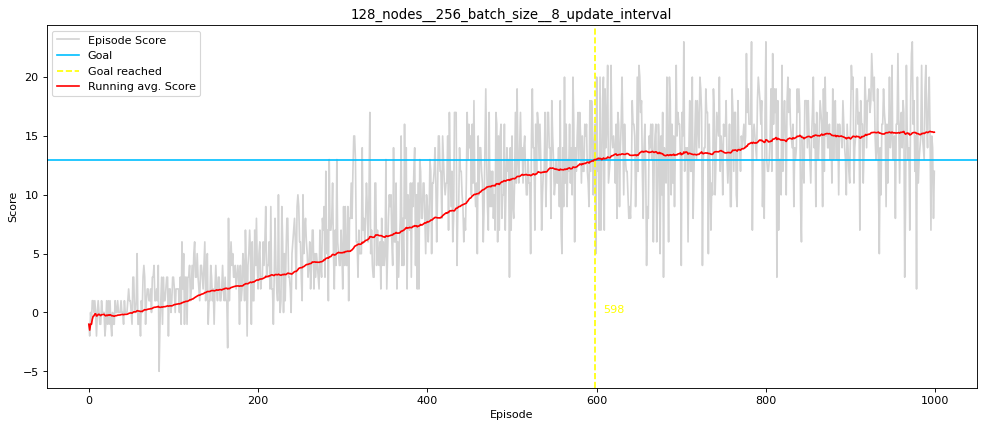

In [5]:
for parameters, result in training_results:
    name, episode_scores, running_avg_score = result
    plot_agent_learning(name, episode_scores, running_avg_score, goal_score)

In [4]:
rows = []
for parameters, result in training_results:
    layer_size, batch_size, update_interval = parameters
    name, episode_scores, running_avg_score = result
    max_avg_score = max(running_avg_score)
    episodes_reaching_goal = np.where(np.array(running_avg_score) >= goal_score)
    episode_solved = episodes_reaching_goal[0][0] if len(episodes_reaching_goal[0]) > 0 else None

    rows.append({
        'Layer Size': layer_size,
        'Batch Size': batch_size,
        'Update Interval': update_interval,
        'Max Avg. Score': max_avg_score,
        'Episodes to Goal': episode_solved
    })

pd.DataFrame(rows)

,Layer Size,Batch Size,Update Interval,Max Avg. Score,Episodes to Goal
0,64,64,4,16.38,474
1,64,64,8,16.36,569
2,64,128,4,16.15,534
3,64,128,8,16.57,520
4,64,256,4,15.82,523
5,64,256,8,16.83,623
6,128,64,4,15.68,551
7,128,64,8,16.14,585
8,128,128,4,14.79,564
9,128,128,8,16.44,653


#### Conclusion

It looks like the initial model with **layer size 64, batch size 64 and update interval 4** is still outperforming the other variants.
Therefore, further improvements will be based on this architecture.